In [57]:
import os
from random import shuffle
import json
from itertools import product

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

from src.models.monuseg.models import get_model
from src.data.monuseg.tf_data import get_dataset, tf_random_crop
from src.models.loss import dice_coe_loss, dice_coe_metric

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

path_indices = "/home/valentin/python_wkspce/2d_bispectrum_cnn/data/indices/monuseg.json"
split = 0

In [3]:
w_fg = 1.9
w_border = 5.0
w_bg = 0.44
def loss(y_true, y_pred):
    l = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    w = (y_true[..., 0] * w_fg + y_true[..., 1] * w_border +
         y_true[..., 2] * w_bg)
    return tf.reduce_mean(w * l, axis=(1, 2))

In [4]:
with open(path_indices, "r") as f:
    indices_list = json.load(f)

ds_train = get_dataset(id_list=indices_list[split]["train"]).take(1)
ds_train = ds_train.cache().repeat(15)
ds_train = ds_train.map(lambda image, seg: tf_random_crop(
    image, seg, rotation_angle="right-angle")).batch(4)

ds_val = get_dataset(id_list=indices_list[split]["val"])
ds_val = ds_val.cache().batch(1)

ds_val_instance = get_dataset(id_list=indices_list[split]["val"],
                              instance=True)
ds_val_instance = ds_val_instance.cache().batch(1)

ds_test = get_dataset(id_list=indices_list[split]["test"], instance=True)
ds_test = ds_test.cache().batch(1)


In [5]:
def rotate_batch(images, angle=90):
    output = np.zeros_like(images)
    for n in range(images.shape[0]):
        output[n, ...] = rotate(images[n, ...], angle=angle, reshape=False)
    return output


In [6]:
model = get_model(
    model_name="BispectUnet",
    output_channels=3,
    n_harmonics=4,
    n_feature_maps=[10, 20, 40],
    radial_profile_type="disks",
)


In [7]:
x, y= next(ds_train.as_numpy_iterator())

In [8]:
y_pred = model(x)

In [9]:
model.summary()

Model: "bispect_unet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (4, 126, 126, 10)         1200      
_________________________________________________________________
sequential_1 (Sequential)    (4, 61, 61, 20)           5260      
_________________________________________________________________
sequential_2 (Sequential)    (4, 57, 57, 40)           20520     
_________________________________________________________________
sequential_3 (Sequential)    (4, 110, 110, 40)         34920     
_________________________________________________________________
sequential_4 (Sequential)    (4, 216, 216, 20)         12460     
_________________________________________________________________
sequential_5 (Sequential)    (4, 216, 216, 3)          63        
_________________________________________________________________
cropping2d (Cropping2D)      multiple                 

In [10]:
model.load_weights("/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/BispectUnet__rotation_True__nh_4__n_train_-1__psize_60x60__20211130-162854/weights/split_0/final")

In [11]:
x_rotated = rotate_batch(x, angle=90)

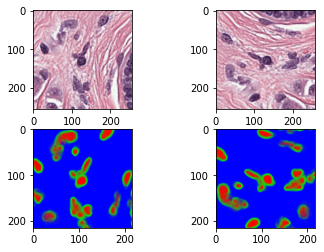

In [12]:
plt.subplot(221)
plt.imshow(x[0,...])
plt.subplot(222)
plt.imshow(x_rotated[0,...])
plt.subplot(223)
plt.imshow(model(x)[0,...])
plt.subplot(224)
plt.imshow(model(x_rotated)[0,...])


In [13]:
y_diff  = model(x) - rotate_batch(model(x_rotated), angle=-90)

In [14]:
np.max(x)

0.99607843

In [15]:
np.sum(np.abs(y_diff)) / len(y_diff.numpy().flatten())

1.3337081155999915e-06

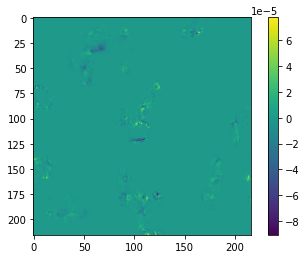

In [16]:
plt.imshow(y_diff[0,...,0])
plt.colorbar()

In [17]:
unet = get_model(
    model_name="Unet",
    output_channels=3,
    n_feature_maps=[8, 16, 32],
)


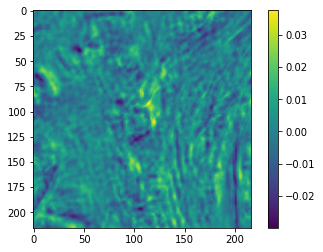

In [18]:
y_diff = unet(x) - rotate_batch(unet(x_rotated), angle=-90)
plt.imshow(y_diff[0, ..., 0])
plt.colorbar()

In [19]:
unet.load_weights("/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/Unet__rotation_True__nh_0__n_train_-1__psize_60x60__20211130-080306/weights/split_2/final")

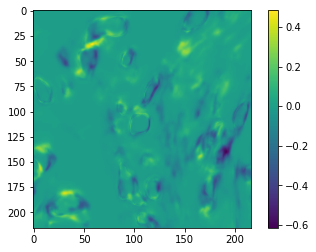

In [20]:
y_diff = unet(x) - rotate_batch(unet(x_rotated), angle=-90)
plt.imshow(y_diff[0, ..., 0])
plt.colorbar()

In [55]:
f = model.down_block_1.get_layer(index=0).conv_ch.filters.numpy()
f.shape

(5, 5, 3, 10, 4)

ValueError: num must be 1 <= num <= 30, not 0

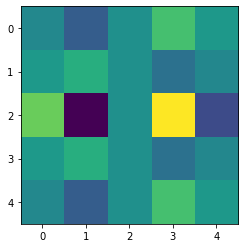

In [61]:
plt.imshow(np.real(f[:, :, 0, 0, 3]))
for k, (i, j) in enumerate(product(range(3), range(10))):
    plt.subplot(3, 10, k)
    plt.imshow(np.real(f[:, :, i, j, 3]))


In [23]:
f = unet.down_block_1.get_layer(index=0).kernel
f.shape

TensorShape([5, 5, 3, 8])

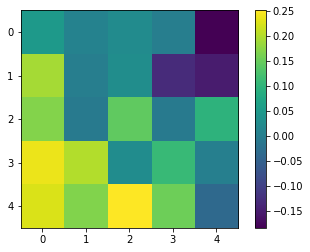

In [24]:
plt.imshow(f[:, :, 0, 0])
plt.colorbar()

In [25]:
radial_profile = model.down_block_1.get_layer(index=0).conv_ch._compute_kernel_profiles()
radial_profile.shape

(5, 5, 2)

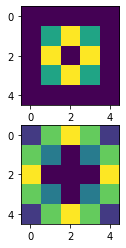

In [26]:
plt.subplot(211)
plt.imshow(radial_profile[:,:,0])
plt.subplot(212)
plt.imshow(radial_profile[:,:,1])

In [27]:
model.down_block_1.get_layer(index=0).indices

ListWrapper([(0, 0), (0, 1), (0, 2), (0, 3), (1, 1), (1, 2)])

In [49]:
model_2 = get_model(
    model_name="BispectUnet",
    output_channels=3,
    n_harmonics=5,
    n_feature_maps=[10, 20, 40],
    radial_profile_type="disks",
)


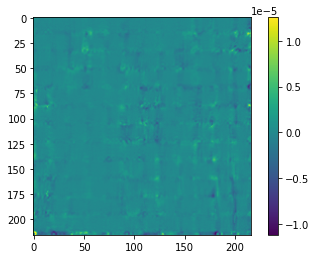

In [50]:
y_diff = model_2(x) - rotate_batch(model_2(x_rotated), angle=-90)
plt.imshow(y_diff[0, ..., 1])
plt.colorbar()

In [51]:
indices = model_2.down_block_1.get_layer(index=0).indices

In [52]:
len(indices)

8

In [53]:
indices

ListWrapper([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3)])